In [1]:
import warnings

import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from safetensors.torch import load_file
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk
from tqdm import tqdm

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta


warnings.filterwarnings("ignore")

def evaluate(model, data):
    problems, answers = data
    
    # Convert single strings to lists if needed
    if isinstance(problems, str):
        problems = [problems]
    if isinstance(answers, str):
        answers = [answers]
    
    # Tokenize the problem texts
    inputs = tokenizer(problems, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)
    
    # For causal language modeling, we need to create targets
    # We'll use the input_ids as targets (shifted for next token prediction)
    targets = input_ids.clone()
    
    # Get model outputs
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    
    # For causal LM, shift logits and targets for next token prediction
    shift_logits = logits[..., :-1, :].contiguous()
    shift_targets = targets[..., 1:].contiguous()
    
    # Reshape for loss calculation
    loss = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)), 
        shift_targets.view(-1), 
        ignore_index=tokenizer.pad_token_id
    )

    return loss, {
        "logits": logits
    }

class ArithmeticDatasetWrapper(Dataset):
    """Wrapper to convert the arithmetic dataset dict format to (x, y) tuples"""
    
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        # Extract the problem text as input (x)
        x = item['problem']
        
        # Extract the answer as target (y) 
        y = item['answer']
        
        return x, y

def create_wrapped_dataloader(dataset_path='arithmetic_dataset', split='train', batch_size=4, shuffle=True):
    """
    Create a DataLoader that returns (x, y) tuples instead of dictionaries
    
    Args:
        dataset_path: Path to the saved dataset
        split: Which split to use ('train', 'test', etc.)
        batch_size: Batch size for the DataLoader
        shuffle: Whether to shuffle the data
    
    Returns:
        DataLoader that yields (x, y) tuples
    """
    # Load the original dataset
    dataset_dict = load_from_disk(dataset_path)
    original_dataset = dataset_dict[split]
    
    # Wrap it to return (x, y) format
    wrapped_dataset = ArithmeticDatasetWrapper(original_dataset)
    
    # Create DataLoader
    loader = DataLoader(wrapped_dataset, batch_size=batch_size, shuffle=shuffle)
    
    return loader


def get_model_checkpoints(path="outputs/arithmetic-grpo/"):
    
    all_checkpointed_models = []
    for checkpoint in os.listdir(path):
        if checkpoint.endswith(".md"):
            continue
        
        # Load the fine-tuned weights
        state_dict = load_file(f"outputs/arithmetic-grpo/{checkpoint}/model.safetensors")
        
        # Create a new model instance and load the weights
        model = AutoModelForCausalLM.from_pretrained("unsloth/Qwen3-0.6B").to("cuda")
        model.load_state_dict(state_dict, strict=False)  # strict=False in case of missing keys
        model.eval()
        
        all_checkpointed_models.append(model)
    return all_checkpointed_models



In [2]:

# Initialize tokenizer at the top level
tokenizer = AutoTokenizer.from_pretrained("unsloth/Qwen3-0.6B")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


all_checkpointed_models = get_model_checkpoints()

loader = create_wrapped_dataloader('arithmetic_dataset', 'train', batch_size=4, shuffle=True)

all_learning_coeff_stats = []
for model in tqdm(all_checkpointed_models):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=4e-4, localization=100.0, nbeta=default_nbeta(loader)),
        num_chains=3,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device="cuda",
        online=True,
    )
    all_learning_coeff_stats.append(learning_coeff_stats)


100%|██████████| 11/11 [10:16<00:00, 56.08s/it]


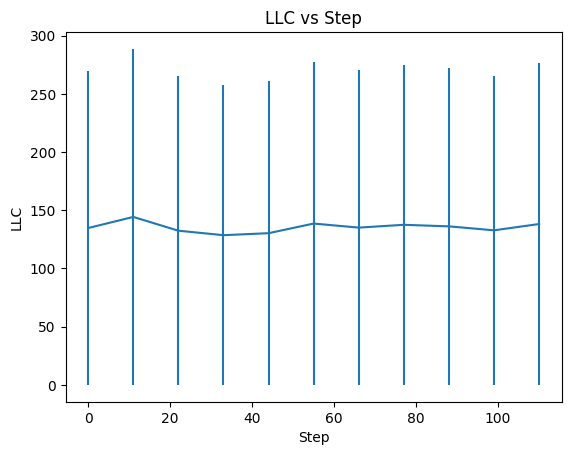

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])


In [ ]:
means = [sum(i["llc/means"])/len(i["llc/means"]) for i in all_learning_coeff_stats]
stderrs = [sum(i["llc/stds"])/len(i["llc/stds"]) for i in all_learning_coeff_stats]

import matplotlib.pyplot as plt
import numpy as np

plt.errorbar(np.array(range(len(means)))*11, means, yerr=stderrs)
plt.xlabel("Step")
plt.ylabel("LLC")
plt.title("LLC vs Step")
plt.savefig("llc_vs_step.png")
plt.show()


trace = learning_coeff_stats["loss/trace"]
print(learning_coeff_stats.keys())

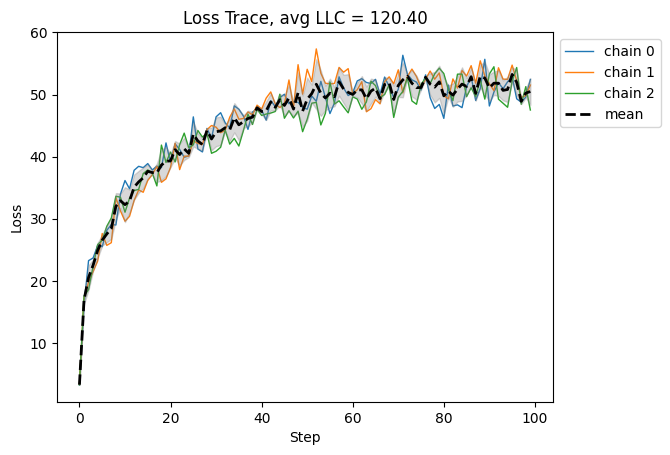

<Figure size 1200x900 with 0 Axes>

In [5]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)